#  Сегментация изображений

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation/data
* https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* https://amaarora.github.io/posts/2020-09-13-unet.html
* https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
* https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8
* https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* https://huggingface.co/docs/transformers/model_doc/segformer
* https://www.kaggle.com/code/damianpanek/segformerb0-people-clothing-segmentation

## Задачи для совместного разбора

1\. Рассмотрите пример работы слоя `ConvTranspose2d`. ConvTranspose2d (транспонированная свёртка) используется для увеличения размеров изображения или карт признаков

In [ ]:
import torch
import torch.nn as nn


conv_transpose = nn.ConvTranspose2d(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    stride=2,
    padding=1
)


input_tensor = torch.tensor([[
    [[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]]
]], dtype=torch.float32)
print(input_tensor.shape)
output = conv_transpose(input_tensor)
print(output.shape)

torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 5, 5])


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Опишите датасет `ClothesSegmentationDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал два элемента: тензор с изображением и тензор с маской. Маска должна быть представлена трехмерным тензором целых чисел. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений и масок. Создайте объект датасета и выведите на экран форму и типы одного изображения и его маски.

- [ ] Проверено на семинаре

In [3]:
import os
import zipfile
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class ClothesSegmentationDataset(Dataset):
    def __init__(self, root_dir, image_folder='jpeg_images/IMAGES',
                 mask_folder='jpeg_masks/MASKS', transform=None):

        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform


        with zipfile.ZipFile(root_dir, 'r') as zip_ref:

            self.image_files = [f for f in zip_ref.namelist()
                             if f.startswith(image_folder) and not f.endswith('/')]

            self.mask_files = [f for f in zip_ref.namelist()
                             if f.startswith(mask_folder) and not f.endswith('/')]

        self.image_files.sort()
        self.mask_files.sort()

        assert len(self.image_files) == len(self.mask_files), \
            "Количество изображений и масок не совпадает"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        with zipfile.ZipFile(self.root_dir, 'r') as zip_ref:
            with zip_ref.open(self.image_files[idx]) as img_file:
                image = Image.open(img_file).convert('RGB')


            with zip_ref.open(self.mask_files[idx]) as mask_file:
                mask = Image.open(mask_file)
                mask = np.array(mask)
                mask = mask[:, :, np.newaxis] if mask.ndim == 2 else mask
                mask = torch.from_numpy(mask).long()


        image = transforms.ToTensor()(image)


        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


class ResizeAndNormalize:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, mask):

        image = transforms.functional.resize(image, self.size)

        image = transforms.functional.normalize(image,
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

        mask = mask.permute(2, 0, 1)
        mask = transforms.functional.resize(mask, self.size,
                                          interpolation=transforms.InterpolationMode.NEAREST)
        mask = mask.permute(1, 2, 0)

        return image, mask


dataset = ClothesSegmentationDataset(
    root_dir='archive.zip',
    transform=ResizeAndNormalize(size=(256, 256))
)


image, mask = dataset[0]


print(f"Изображение - форма: {image.shape}, тип: {image.dtype}")
print(f"Маска - форма: {mask.shape}, тип: {mask.dtype}")



Изображение - форма: torch.Size([3, 256, 256]), тип: torch.float32
Маска - форма: torch.Size([256, 256, 1]), тип: torch.int64


<p class="task" id="2"></p>

2\. Напишите функцию `show_image_with_mask`, которая выводит рядом два изображения: фотографию и маску. Продемонстрируйте работу функции, взяв один пример из созданного датасета.

- [ ] Проверено на семинаре

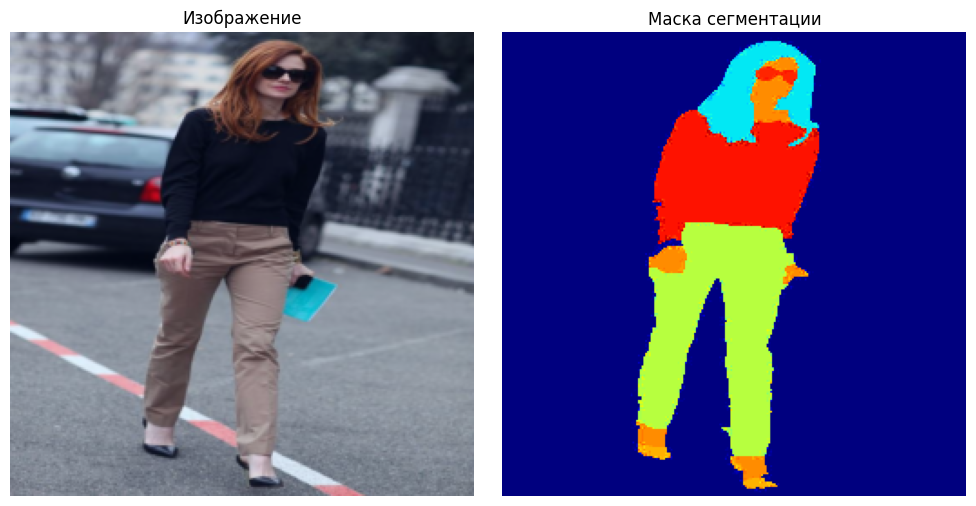

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_image_with_mask(image, mask, figsize=(10, 5)):


    image = image.numpy()
    mask = mask.numpy()


    image = np.transpose(image, (1, 2, 0))

    if image.min() < 0 or image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())

  #(H, W, 1) -> (H, W)
    mask = mask.squeeze()


    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Изображение')
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='jet')
    plt.title('Маска сегментации')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


image, mask = dataset[100]


show_image_with_mask(image, mask)

<p class="task" id="3"></p>

3\. Реализуйте архитектуру U-Net. Реализуйте модель таким образом, чтобы на выходе для каждого изображения получался тензор размера `n_classes x h x w`, где `n_classes` - количество уникальных значений в масках, а `h` и `w` - размер исходного изображения. Возьмите один пример из набора данных и пропустите его через сеть. Выведите форму полученного результата на экран.

- [ ] Проверено на семинаре

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024 + 512, 512, bilinear)
        self.up2 = Up(512 + 256, 256, bilinear)
        self.up3 = Up(256 + 128, 128, bilinear)
        self.up4 = Up(128 + 64, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        # Масштабируем выход до исходного размера изображения
        if logits.shape[2:] != x.shape[2:]:
            logits = F.interpolate(logits, size=x.shape[2:], mode='bilinear', align_corners=True)

        return logits


sample_mask = dataset[0][1]
n_classes = len(torch.unique(sample_mask))
print(f"Количество классов: {n_classes}")

model = UNet(n_channels=3, n_classes=n_classes)


sample_image, _ = dataset[0]

sample_image = sample_image.unsqueeze(0)


with torch.no_grad():
    output = model(sample_image)


print(f"Форма выхода модели: {output.shape}")

Количество классов: 53
Форма выхода модели: torch.Size([1, 53, 256, 256])


<p class="task" id="4"></p>

4\.  Разбейте набор данных на обучающее и валидационное множество. Обучите модель U-Net для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Обратите внимание, что выборка является несбалансированной. При расчете функции потерь примените любую известную вам технику для работы с несбалансированными выборками.

При создании датасета допускается использовать преобразования, уменьшающие размер изображений (для ускорения процесса обучения).

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

Разбиение данных

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import numpy as np
from sklearn.metrics import accuracy_score, jaccard_score

class RescaleTransform:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, image, mask):
        image = transforms.functional.resize(image, self.output_size)


        mask = mask.permute(2, 0, 1)
        mask = transforms.functional.resize(mask, self.output_size,
                                         interpolation=transforms.InterpolationMode.NEAREST)
        mask = mask.permute(1, 2, 0)

        return image, mask


full_dataset = ClothesSegmentationDataset(
    root_dir='archive.zip',
    transform=RescaleTransform((256, 256))
)


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


print(f"Обучающих примеров: {len(train_dataset)}")
print(f"Валидационных примеров: {len(val_dataset)}")

Обучающих примеров: 800
Валидационных примеров: 200


Модель и функция потерь для несбалансированных данных

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights=None):
        super().__init__()
        self.class_weights = class_weights

    def forward(self, inputs, targets):

        targets = targets.squeeze(3).long()
        if self.class_weights is not None:
            weights = self.class_weights[targets]
        else:
            weights = torch.ones_like(targets, dtype=torch.float)
        loss = F.cross_entropy(inputs, targets, reduction='none')
        weighted_loss = (loss * weights).mean()

        return weighted_loss

def calculate_class_weights(dataset, n_classes):
    class_counts = torch.zeros(n_classes)

    for _, mask in dataset:
        mask = mask.squeeze().long()
        counts = torch.bincount(mask.view(-1), minlength=n_classes)
        class_counts += counts

    class_weights = 1.0 / (class_counts + 1e-6)
    class_weights /= class_weights.sum()
    return class_weights


def get_num_classes(dataset):
    max_class = 0
    for _, mask in dataset:
        current_max = mask.max().item()
        if current_max > max_class:
            max_class = current_max
    return max_class + 1


if __name__ == "__main__":

    n_classes = get_num_classes(train_dataset)
    print(f"Обнаружено классов: {n_classes}")


    class_weights = calculate_class_weights(train_dataset, n_classes)
    print("Веса классов:", class_weights)


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(n_channels=3, n_classes=n_classes).to(device)
    criterion = WeightedCrossEntropyLoss(class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Обнаружено классов: 65
Веса классов: tensor([1.8900e-08, 3.0493e-06, 1.4270e-06, 8.1135e-06, 2.4128e-06, 1.7153e-06,
        1.1732e-05, 1.0593e-05, 8.8127e-05, 6.7706e-05, 5.1415e-06, 1.4102e-05,
        1.5959e-05, 6.1063e-07, 5.2509e-07, 1.7755e-05, 3.3733e-05, 2.9744e-05,
        1.3952e-05, 1.4017e-06, 8.4698e-06, 2.8012e-05, 3.1333e-05, 4.1573e-05,
        3.2240e-06, 1.4713e-06, 1.0342e-05, 8.6841e-06, 3.9926e-05, 4.2241e-05,
        1.9852e-05, 6.5233e-07, 1.5818e-05, 3.8547e-06, 3.6333e-05, 7.0390e-06,
        1.5553e-05, 5.4085e-06, 2.4415e-06, 1.9113e-06, 3.5452e-06, 5.9325e-07,
        1.3898e-06, 1.2398e-05, 1.8899e-05, 5.5753e-06, 2.1696e-06, 1.6786e-05,
        2.4471e-06, 9.0626e-06, 5.4813e-05, 3.3041e-06, 5.5198e-05, 4.2601e-05,
        9.5408e-06, 5.5920e-06, 6.7289e-05, 2.0261e-04, 4.3151e-04, 1.1774e-03,
        3.3247e-03, 1.0782e-02, 3.9722e-02, 1.8868e-01, 7.5472e-01])


Функции для вычисления метрик

In [ ]:
def calculate_metrics(preds, labels):


    preds = torch.argmax(preds, dim=1).cpu().numpy()
    labels = labels.squeeze(3).cpu().numpy()



    acc = accuracy_score(labels.flatten(), preds.flatten())


    iou = jaccard_score(labels.flatten(), preds.flatten(),
                       average='macro', zero_division=0)

    return acc, iou

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    running_iou = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc, iou = calculate_metrics(outputs, masks)


        running_loss += loss.item()
        running_acc += acc
        running_iou += iou

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_acc / len(loader)
    epoch_iou = running_iou / len(loader)

    return epoch_loss, epoch_acc, epoch_iou

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    running_iou = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            acc, iou = calculate_metrics(outputs, masks)

            running_loss += loss.item()
            running_acc += acc
            running_iou += iou

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_acc / len(loader)
    epoch_iou = running_iou / len(loader)

    return epoch_loss, epoch_acc, epoch_iou

Процесс обучения

Epoch 1/2:
Train Loss: 0.0000 | Val Loss: 0.0000
Train Acc: 0.0329 | Val Acc: 0.0269
Train IoU: 0.0026 | Val IoU: 0.0032
--------------------------------------------------
Epoch 2/2:
Train Loss: 0.0000 | Val Loss: 0.0000
Train Acc: 0.0306 | Val Acc: 0.0377
Train IoU: 0.0053 | Val IoU: 0.0069
--------------------------------------------------


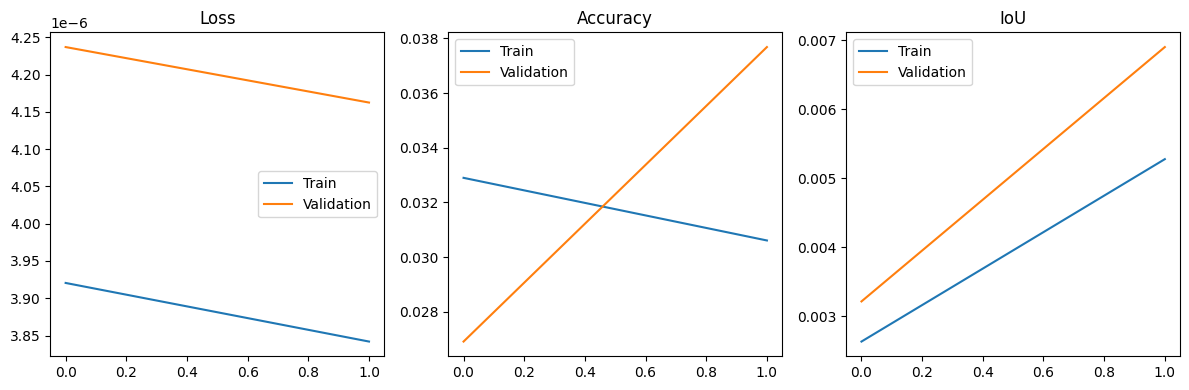

In [ ]:
num_epochs = 2
best_iou = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_ious = []
val_ious = []

for epoch in range(num_epochs):

    train_loss, train_acc, train_iou = train_epoch(model, train_loader, criterion, optimizer, device)

    val_loss, val_acc, val_iou = validate_epoch(model, val_loader, criterion, device)


    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_ious.append(train_iou)
    val_ious.append(val_iou)


    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), 'best_unet_model.pth')


    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print(f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')
    print(f'Train IoU: {train_iou:.4f} | Val IoU: {val_iou:.4f}')
    print('-' * 50)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_ious, label='Train')
plt.plot(val_ious, label='Validation')
plt.title('IoU')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

Визуализация предсказаний

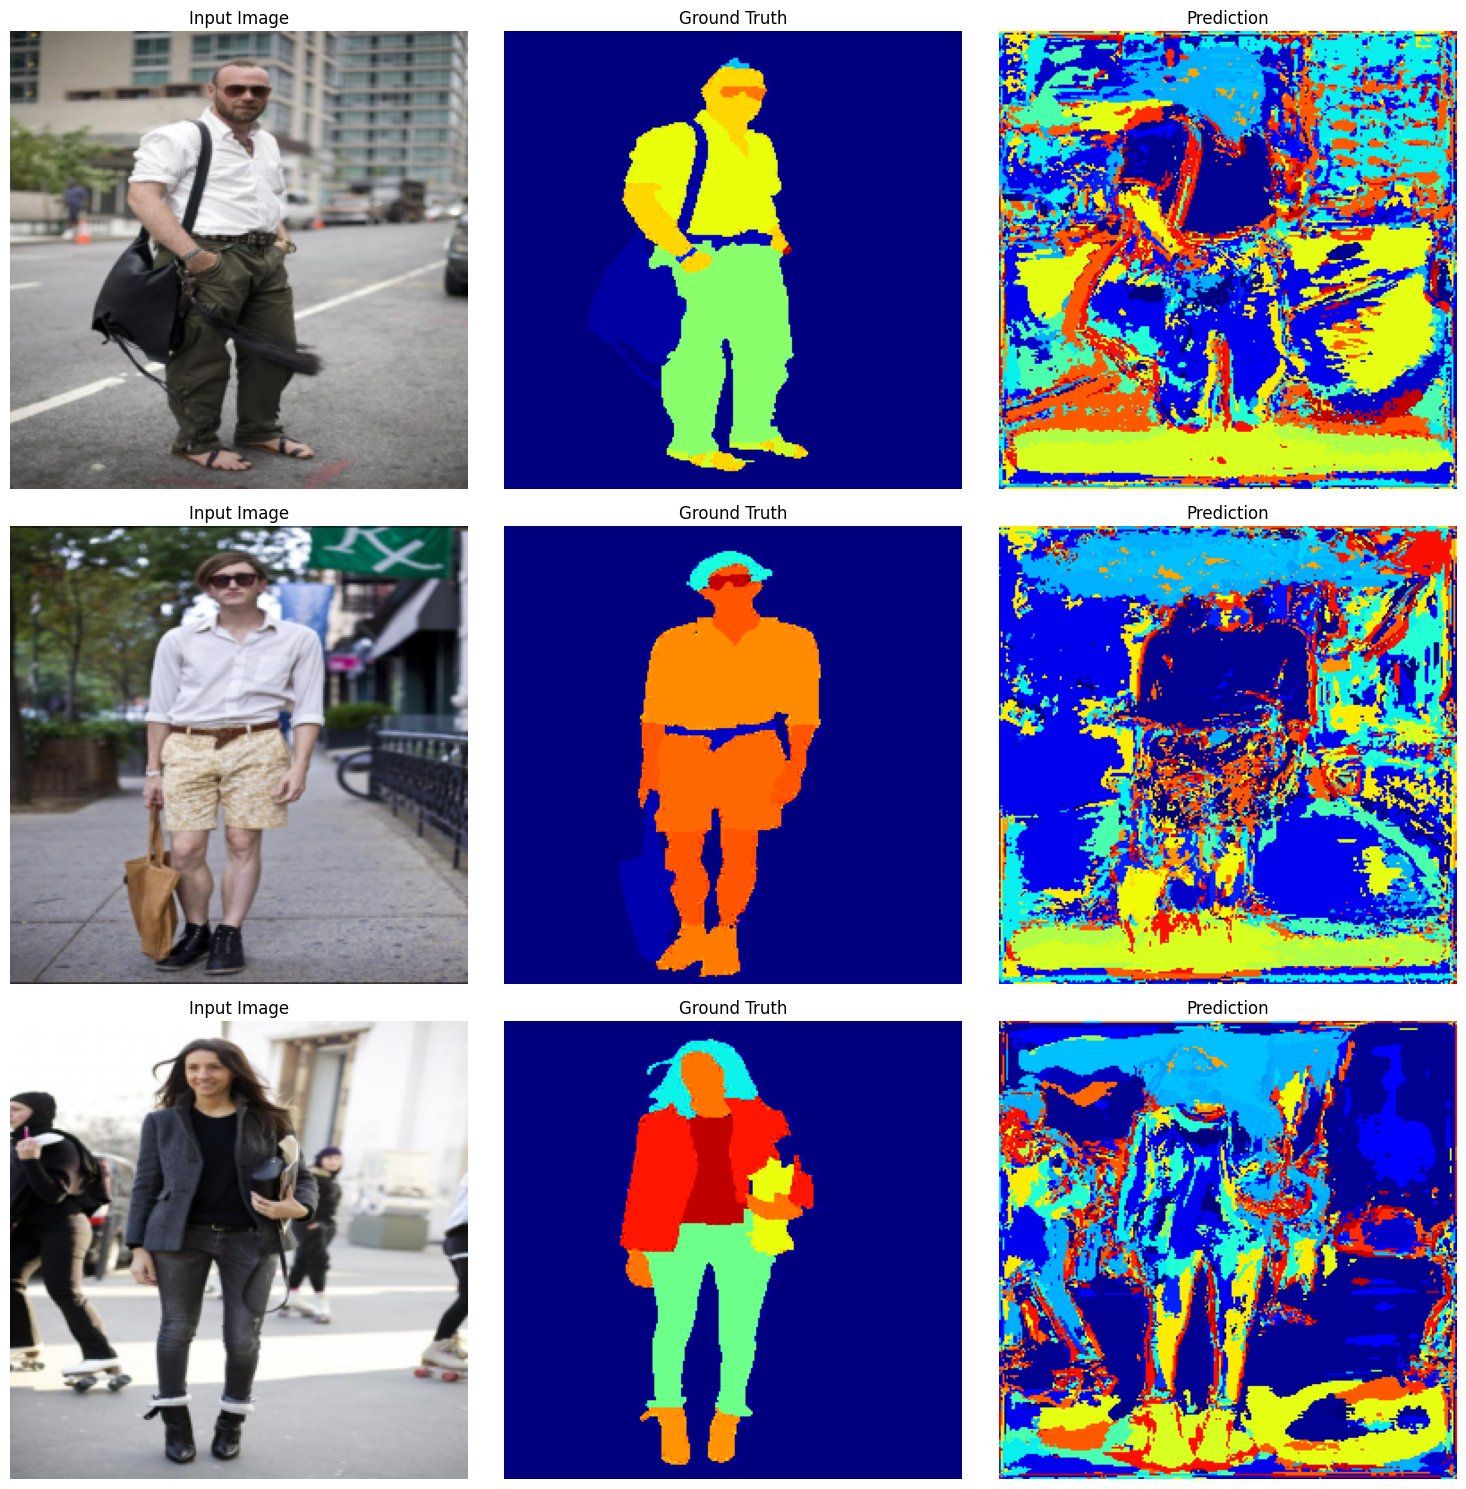

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    indices = torch.randint(0, len(dataset), (num_samples,))

    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        image, true_mask = dataset[idx]

        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        true_mask = true_mask.squeeze().numpy()

        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image.permute(1, 2, 0).numpy())
        plt.title('Input Image')
        plt.axis('off')


        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(true_mask, cmap='jet')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_mask, cmap='jet')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()


model.load_state_dict(torch.load('best_unet_model.pth'))


visualize_predictions(model, val_dataset, device, num_samples=3)

<p class="task" id="5"></p>

5\.  Обучите модуль `SegformerForSemanticSegmentation` из пакета `transformers` для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Для оптимизации используйте значение функции потерь, которое возвращает вам модель.

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

Train samples: 800, Val samples: 200
Number of classes: 61


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/2


Validation: 100%|██████████| 50/50 [04:01<00:00,  4.83s/it]


Train Loss: 2.6686 | Val Loss: 1.8639
Train Acc: 0.6541 | Val Acc: 0.6878
Saved new best model

Epoch 2/2


Validation: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it]


Train Loss: 1.4807 | Val Loss: 1.1170
Train Acc: 0.7679 | Val Acc: 0.8319
Saved new best model


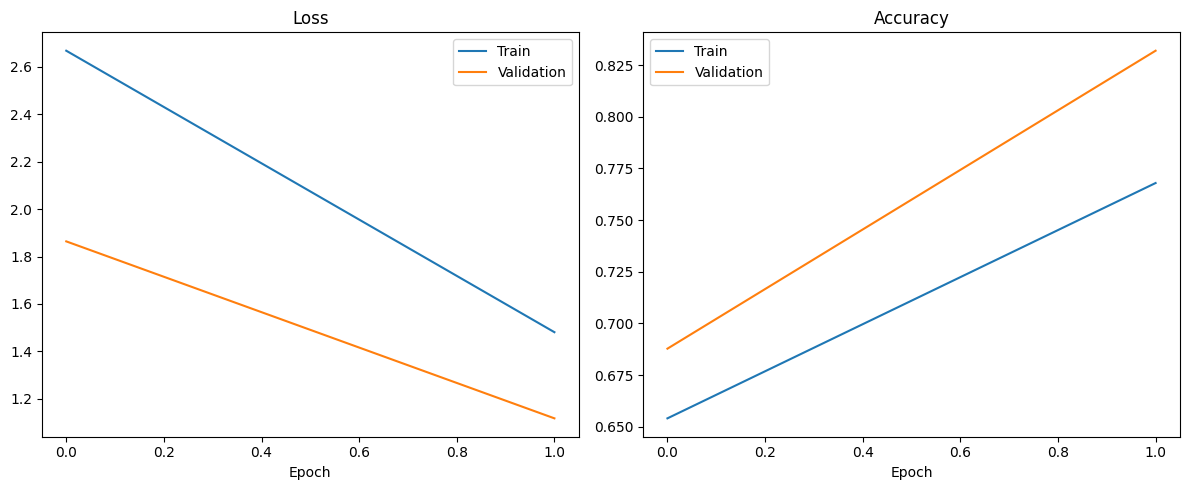

In [18]:
import torch
from torch.utils.data import DataLoader, random_split
import numpy as np
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from torch.optim import AdamW
import zipfile
from PIL import Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

class SegformerDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, feature_extractor, image_folder='jpeg_images/IMAGES',
                 mask_folder='jpeg_masks/MASKS', transform=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.feature_extractor = feature_extractor

        with zipfile.ZipFile(root_dir, 'r') as zip_ref:
            self.image_files = [f for f in zip_ref.namelist()
                             if f.startswith(image_folder) and not f.endswith('/')]
            self.mask_files = [f for f in zip_ref.namelist()
                             if f.startswith(mask_folder) and not f.endswith('/')]

        self.image_files.sort()
        self.mask_files.sort()
        assert len(self.image_files) == len(self.mask_files)

        # First load a mask to determine number of classes
        sample_mask = self._load_mask_without_clamping(0)
        self.num_classes = len(torch.unique(sample_mask))

    def _load_image(self, idx):
        with zipfile.ZipFile(self.root_dir, 'r') as zip_ref:
            with zip_ref.open(self.image_files[idx]) as img_file:
                image = Image.open(img_file).convert('RGB')
        return image

    def _load_mask_without_clamping(self, idx):
        """Helper method to load mask without clamping, used in __init__"""
        with zipfile.ZipFile(self.root_dir, 'r') as zip_ref:
            with zip_ref.open(self.mask_files[idx]) as mask_file:
                mask = Image.open(mask_file)
                mask = torch.from_numpy(np.array(mask)).long()
        return mask

    def _load_mask(self, idx):
        mask = self._load_mask_without_clamping(idx)
        mask = torch.clamp(mask, 0, self.num_classes-1)
        return mask

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self._load_image(idx)
        mask = self._load_mask(idx)

        if self.transform:
            image, mask = self.transform(image, mask)

        inputs = self.feature_extractor(images=image, segmentation_maps=mask, return_tensors="pt")

        inputs['pixel_values'] = inputs['pixel_values'].squeeze()
        inputs['labels'] = inputs['labels'].squeeze()

        return inputs

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
feature_extractor.reduce_labels = True


full_dataset = SegformerDataset(
    root_dir='archive.zip',
    feature_extractor=feature_extractor,
    transform=None
)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print(f"Number of classes: {full_dataset.num_classes}")


model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    num_labels=full_dataset.num_classes,
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

def compute_metrics(preds, labels):
    preds = torch.nn.functional.interpolate(
        preds,
        size=labels.shape[-2:],
        mode='bilinear',
        align_corners=False
    )
    preds = torch.argmax(preds, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()


    preds = preds.flatten()
    labels = labels.flatten()

    acc = accuracy_score(labels, preds)
    return acc
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    total_acc = 0

    for batch in tqdm(loader, desc="Training"):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        acc = compute_metrics(logits, labels)

        total_loss += loss.item()
        total_acc += acc

    avg_loss = total_loss / len(loader)
    avg_acc = total_acc / len(loader)

    return avg_loss, avg_acc

def validate_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            acc = compute_metrics(logits, labels)

            total_loss += loss.item()
            total_acc += acc

    avg_loss = total_loss / len(loader)
    avg_acc = total_acc / len(loader)

    return avg_loss, avg_acc
def validate_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            acc = compute_metrics(logits, labels)

            total_loss += loss.item()
            total_acc += acc

    avg_loss = total_loss / len(loader)
    avg_acc = total_acc / len(loader)

    return avg_loss, avg_acc


num_epochs = 2
best_val_loss = float('inf')

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_segformer_model.pth")
        print("Saved new best model")


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('segformer_training.png')
plt.show()



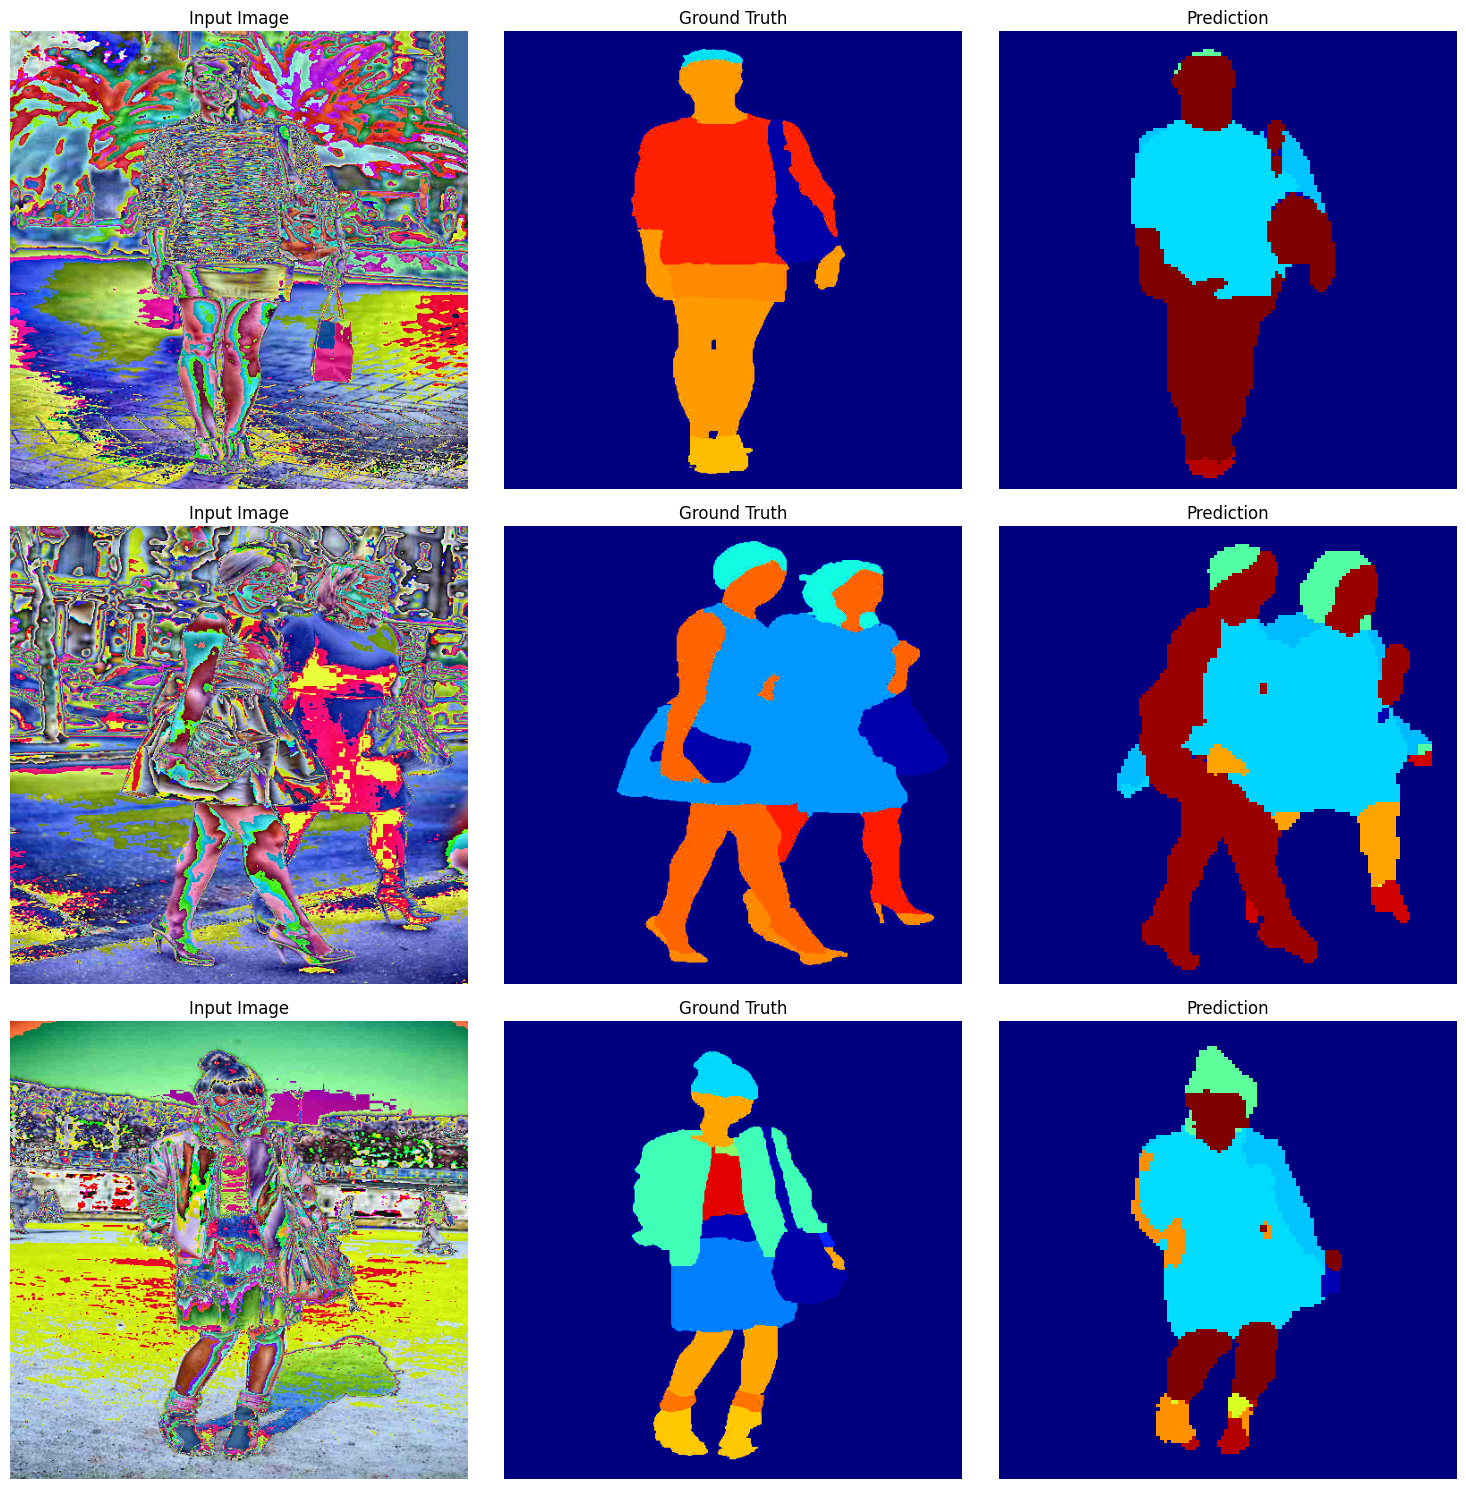

In [19]:
def visualize_predictions(model, dataset, feature_extractor, device, num_samples=3):
    model.eval()
    indices = torch.randint(0, len(dataset), (num_samples,))

    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        inputs = dataset[idx]
        pixel_values = inputs["pixel_values"].unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)
            preds = torch.argmax(outputs.logits, dim=1).squeeze().cpu().numpy()


        image_tensor = inputs["pixel_values"]
        image = transforms.ToPILImage()(image_tensor)


        true_mask = inputs["labels"].numpy()

        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(true_mask, cmap='jet')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(preds, cmap='jet')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('segformer_predictions.png')
    plt.show()


model.load_state_dict(torch.load("best_segformer_model.pth"))
model.to(device)

visualize_predictions(model, val_dataset, feature_extractor, device, num_samples=3)